In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=2a44e59c435e776cec148cc6bcc53c81408af19b52613440ba71471aabd2a292
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import when

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Using Train data to do stratified sampling

In [ ]:
#Create Spark session
spark = SparkSession.builder.appName("CreditScorePrediction").getOrCreate()

Step 2: Load dataset

"/content/drive/MyDrive/CSCI316/GroupAssignment/train.csv"
"/content/drive/MyDrive/CSCI316/GroupAssignment/test.csv"

In [ ]:
#Load training and testing datasets
training_data = spark.read.csv("/content/drive/MyDrive/CSCI316/GroupAssignment/train.csv", header=True, inferSchema=True)
#testing_data = spark.read.csv("/content/drive/MyDrive/CSCI316/GroupAssignment/test.csv", header=True, inferSchema=True)

#Data Visualisation

In [ ]:
training_data.show()

+------+-----------+--------+---------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|           Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+---------------+----+-----------+

In [ ]:
# Print the schema to see data types
training_data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable = true

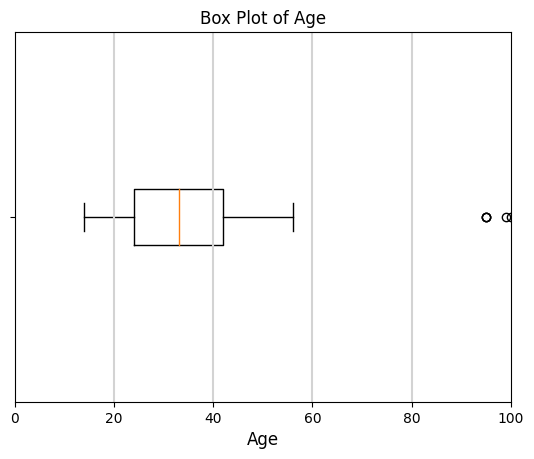

In [ ]:
# Convert column to numeric (if it's not already)
training_data = training_data.withColumn("Age", training_data["Age"].cast("double"))

# Set the age range to 0-100
age_range = (0, 100)

# Filter out rows with missing or invalid "Age" values
filtered_data = training_data.filter(col("Age").isNotNull() & (col("Age") >= age_range[0]) & (col("Age") <= age_range[1]))

# Convert the "Age" column to numeric
filtered_data = filtered_data.withColumn("Age", filtered_data["Age"].cast("double"))

# Create a boxplot using matplotlib
age_data = filtered_data.select("Age").toPandas()

fig, ax = plt.subplots()

ax.boxplot(age_data, vert=False)

# Set x-axis limits for better readability
ax.set_xlim(age_range[0], age_range[1])

# Set labels and title
ax.set_xlabel('Age', fontsize=12)
ax.set_title('Box Plot of Age')

# Add vertical lines to indicate the age range
ax.axvline(20, color='lightgrey', linestyle='-')
ax.axvline(40, color='lightgrey', linestyle='-')
ax.axvline(60, color='lightgrey', linestyle='-')
ax.axvline(80, color='lightgrey', linestyle='-')

# Remove y-axis label
ax.set_yticklabels([])

# Show the plot
plt.show()


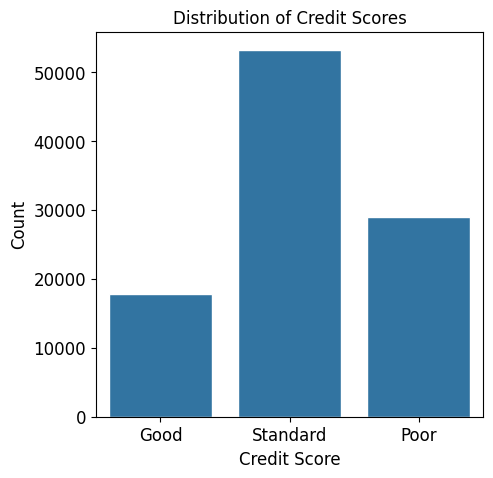

In [ ]:
# Set font sizes for better readability
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Create a figure for the plot
plt.figure(figsize=(5, 5))

# Set the title of the plot
plt.title("Distribution of Credit Scores", fontsize=12)

# Set the style and palette for the plot
sns.set(style="whitegrid", palette="pastel")

# Assuming 'Credit_Score' is a column in your Spark DataFrame
# Extract the 'Credit_Score' column and convert it to a Pandas Series for plotting
sns.countplot(x=training_data.select('Credit_Score').toPandas()['Credit_Score'])

# Set labels for x and y axes
plt.xlabel("Credit Score", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Display the plot
plt.show()

<ipython-input-10-ca5608de9689>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pandas_training_data.corr()


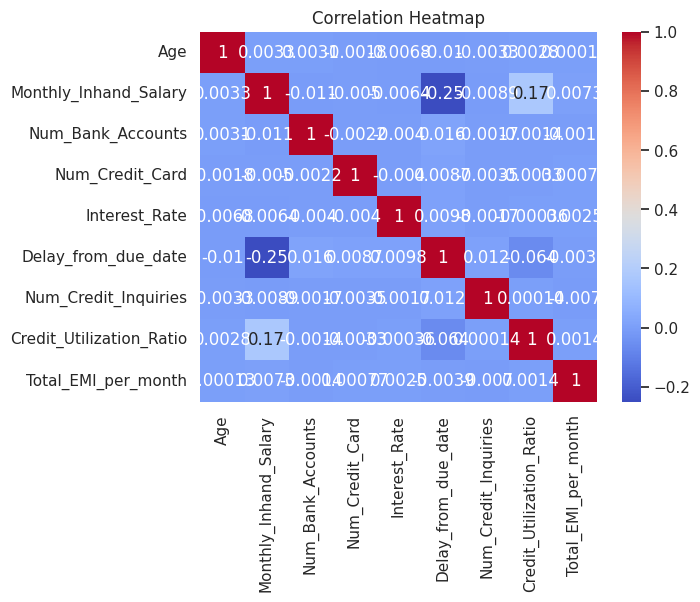

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_training_data = training_data.toPandas()

correlation_matrix = pandas_training_data.corr()

# Generate the heatmap with correlation values annotated
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the title for the heatmap
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

# (b) Prepare the data for machine learning algorithms

In [ ]:
# Data cleaning! Read more: https://monkeylearn.com/blog/data-cleaning-techniques/
# Remove uneccessary columns that does not affect Credit Score
columns_to_remove = ['ID','Customer_ID','Month','Name','SSN','Type_of_Loan']
training_data = training_data.drop(*columns_to_remove)

In [ ]:
# Check that uneccessary colums has been removed
print(training_data.columns)

['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Credit_Score']


In [ ]:
# List of columns with the same issue
columns_with_underscores = ['Age', 'Annual_Income' , 'Monthly_Inhand_Salary', 'Num_of_Delayed_Payment','Num_of_Loan',
                            'Monthly_Balance',
                            'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly']

# Apply the cleaning operation to each column, removing _
for column in columns_with_underscores:

    training_data = training_data.withColumn(column, regexp_replace(col(column), "_", ""))
    training_data = training_data.withColumn(column, regexp_replace(col(column), "^_+|_+$", ""))


    # Set values in column to be >= 0. If <0, set as NULL
    training_data = training_data.withColumn(column,
                                          when((col(column) < 0), None)
                                        .otherwise(col(column)))


    # If "", set to NULL
    training_data = training_data.withColumn(column, when(col(column) == "", None).otherwise(col(column)))


In [ ]:
# Replace null with relevant values to reduce data loss
#Num_of_Delayed_Payment (if left blank = no delayed payments)
training_data = training_data.na.fill({'Num_of_Delayed_Payment': 0})

In [ ]:
# Filter rows where 'Age' is between 1 and 100 (inclusive)
training_data = training_data[(training_data['Age'] > 0) & (training_data['Age'] <= 100)]

In [ ]:
#Check that numerical datas are cleaned
training_data.show(30)

+---+------------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|Age|  Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+------------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----

In [ ]:
# Replace underscores in 'Credit_Mix' column
training_data = training_data.withColumn('Credit_Mix', regexp_replace('Credit_Mix', '_', ""))

# Replace underscores in 'Occupation' column
training_data = training_data.withColumn('Occupation', regexp_replace('Occupation', '_______',""))

training_data = training_data.withColumn('Num_of_Loan', regexp_replace('Num_of_Loan','-100',''))

In [ ]:
# Replace empty strings with None
training_data = training_data.withColumn("Occupation", when(col("Occupation") == "", None).otherwise(col("Occupation")))
training_data = training_data.withColumn('Credit_Mix', when(col('Credit_Mix') == "", None).otherwise(col('Credit_Mix')))
training_data = training_data.withColumn('Num_of_Loan', when(col('Num_of_Loan') == "", None).otherwise(col('Num_of_Loan')))

In [ ]:
#delete null occupation n monthly balance n credit mix
training_data = training_data.filter(col("Occupation").isNotNull())#6873 delete
training_data = training_data.filter(col("Monthly_Balance").isNotNull())#1105 delete
training_data = training_data.filter(col("Credit_Mix").isNotNull())#18030 delete

In [ ]:
# Calculate mean values
mean_values = training_data.agg(*(mean(c).alias(c) for c in ['Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Loan','Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Amount_invested_monthly'])).collect()[0]


In [ ]:
#Checking Mean values
print(mean_values)

Row(Annual_Income=177227.61001453403, Monthly_Inhand_Salary=4161.717078373136, Num_of_Loan=7.145941442165734, Changed_Credit_Limit=10.554407131553408, Num_Credit_Inquiries=27.701985332034607, Amount_invested_monthly=623.5150497192653)


In [ ]:
# Fill missing values with mean values
for column in ['Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Loan', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Amount_invested_monthly']:
    training_data = training_data.withColumn(column, when(isnull(column), mean_values[column]).otherwise(col(column)))

In [ ]:
 # Remove rows with weird values
training_data = training_data.filter(training_data['Payment_Behaviour'] != '!@9#%8')
training_data = training_data.filter(training_data['Credit_History_Age'] != 'NA')

In [ ]:
training_data.show(30)

+---+------------+-------------+---------------------+-----------------+---------------+-------------+-----------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|Age|  Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|      Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+---+------------+-------------+---------------------+-----------------+---------------+-------------+-----------------+-------------------+----------------------+--------------------+------------------

In [ ]:
# Drop rows with missing values in the 'Credit_History_Age' column
training_data = training_data.dropna(subset=['Credit_History_Age'])

In [ ]:
#@title credit history age
#Define the columns and corresponding categories
categorical_columns = ['Credit_History_Age']
categories = {
    'Credit_History_Age': ['0 Years and 1 Months',
                      '0 Years and 10 Months',
                      '0 Years and 11 Months',
                      '0 Years and 2 Months',
                      '0 Years and 3 Months',
                      '0 Years and 4 Months',
                      '0 Years and 5 Months',
                      '0 Years and 6 Months',
                      '0 Years and 7 Months',
                      '0 Years and 8 Months',
                      '0 Years and 9 Months',
                      '1 Years and 0 Months',
                      '1 Years and 1 Months',
                      '1 Years and 10 Months',
                      '1 Years and 11 Months',
                      '1 Years and 2 Months',
                      '1 Years and 3 Months',
                      '1 Years and 4 Months',
                      '1 Years and 5 Months',
                      '1 Years and 6 Months',
                      '1 Years and 7 Months',
                      '1 Years and 8 Months',
                      '1 Years and 9 Months',
                      '10 Years and 0 Months',
                      '10 Years and 1 Months',
                      '10 Years and 10 Months',
                      '10 Years and 11 Months',
                      '10 Years and 2 Months',
                      '10 Years and 3 Months',
                      '10 Years and 4 Months',
                      '10 Years and 5 Months',
                      '10 Years and 6 Months',
                      '10 Years and 7 Months',
                      '10 Years and 8 Months',
                      '10 Years and 9 Months',
                      '11 Years and 0 Months',
                      '11 Years and 1 Months',
                      '11 Years and 10 Months',
                      '11 Years and 11 Months',
                      '11 Years and 2 Months',
                      '11 Years and 3 Months',
                      '11 Years and 4 Months',
                      '11 Years and 5 Months',
                      '11 Years and 6 Months',
                      '11 Years and 7 Months',
                      '11 Years and 8 Months',
                      '11 Years and 9 Months',
                      '12 Years and 0 Months',
                      '12 Years and 1 Months',
                      '12 Years and 10 Months',
                      '12 Years and 11 Months',
                      '12 Years and 2 Months',
                      '12 Years and 3 Months',
                      '12 Years and 4 Months',
                      '12 Years and 5 Months',
                      '12 Years and 6 Months',
                      '12 Years and 7 Months',
                      '12 Years and 8 Months',
                      '12 Years and 9 Months',
                      '13 Years and 0 Months',
                      '13 Years and 1 Months',
                      '13 Years and 10 Months',
                      '13 Years and 11 Months',
                      '13 Years and 2 Months',
                      '13 Years and 3 Months',
                      '13 Years and 4 Months',
                      '13 Years and 5 Months',
                      '13 Years and 6 Months',
                      '13 Years and 7 Months',
                      '13 Years and 8 Months',
                      '13 Years and 9 Months',
                      '14 Years and 0 Months',
                      '14 Years and 1 Months',
                      '14 Years and 10 Months',
                      '14 Years and 11 Months',
                      '14 Years and 2 Months',
                      '14 Years and 3 Months',
                      '14 Years and 4 Months',
                      '14 Years and 5 Months',
                      '14 Years and 6 Months',
                      '14 Years and 7 Months',
                      '14 Years and 8 Months',
                      '14 Years and 9 Months',
                      '15 Years and 0 Months',
                      '15 Years and 1 Months',
                      '15 Years and 10 Months',
                      '15 Years and 11 Months',
                      '15 Years and 2 Months',
                      '15 Years and 3 Months',
                      '15 Years and 4 Months',
                      '15 Years and 5 Months',
                      '15 Years and 6 Months',
                      '15 Years and 7 Months',
                      '15 Years and 8 Months',
                      '15 Years and 9 Months',
                      '16 Years and 0 Months',
                      '16 Years and 1 Months',
                      '16 Years and 10 Months',
                      '16 Years and 11 Months',
                      '16 Years and 2 Months',
                      '16 Years and 3 Months',
                      '16 Years and 4 Months',
                      '16 Years and 5 Months',
                      '16 Years and 6 Months',
                      '16 Years and 7 Months',
                      '16 Years and 8 Months',
                      '16 Years and 9 Months',
                      '17 Years and 0 Months',
                      '17 Years and 1 Months',
                      '17 Years and 10 Months',
                      '17 Years and 11 Months',
                      '17 Years and 2 Months',
                      '17 Years and 3 Months',
                      '17 Years and 4 Months',
                      '17 Years and 5 Months',
                      '17 Years and 6 Months',
                      '17 Years and 7 Months',
                      '17 Years and 8 Months',
                      '17 Years and 9 Months',
                      '18 Years and 0 Months',
                      '18 Years and 1 Months',
                      '18 Years and 10 Months',
                      '18 Years and 11 Months',
                      '18 Years and 2 Months',
                      '18 Years and 3 Months',
                      '18 Years and 4 Months',
                      '18 Years and 5 Months',
                      '18 Years and 6 Months',
                      '18 Years and 7 Months',
                      '18 Years and 8 Months',
                      '18 Years and 9 Months',
                      '19 Years and 0 Months',
                      '19 Years and 1 Months',
                      '19 Years and 10 Months',
                      '19 Years and 11 Months',
                      '19 Years and 2 Months',
                      '19 Years and 3 Months',
                      '19 Years and 4 Months',
                      '19 Years and 5 Months',
                      '19 Years and 6 Months',
                      '19 Years and 7 Months',
                      '19 Years and 8 Months',
                      '19 Years and 9 Months',
                      '2 Years and 0 Months',
                      '2 Years and 1 Months',
                      '2 Years and 10 Months',
                      '2 Years and 11 Months',
                      '2 Years and 2 Months',
                      '2 Years and 3 Months',
                      '2 Years and 4 Months',
                      '2 Years and 5 Months',
                      '2 Years and 6 Months',
                      '2 Years and 7 Months',
                      '2 Years and 8 Months',
                      '2 Years and 9 Months',
                      '20 Years and 0 Months',
                      '20 Years and 1 Months',
                      '20 Years and 10 Months',
                      '20 Years and 11 Months',
                      '20 Years and 2 Months',
                      '20 Years and 3 Months',
                      '20 Years and 4 Months',
                      '20 Years and 5 Months',
                      '20 Years and 6 Months',
                      '20 Years and 7 Months',
                      '20 Years and 8 Months',
                      '20 Years and 9 Months',
                      '21 Years and 0 Months',
                      '21 Years and 1 Months',
                      '21 Years and 10 Months',
                      '21 Years and 11 Months',
                      '21 Years and 2 Months',
                      '21 Years and 3 Months',
                      '21 Years and 4 Months',
                      '21 Years and 5 Months',
                      '21 Years and 6 Months',
                      '21 Years and 7 Months',
                      '21 Years and 8 Months',
                      '21 Years and 9 Months',
                      '22 Years and 0 Months',
                      '22 Years and 1 Months',
                      '22 Years and 10 Months',
                      '22 Years and 11 Months',
                      '22 Years and 2 Months',
                      '22 Years and 3 Months',
                      '22 Years and 4 Months',
                      '22 Years and 5 Months',
                      '22 Years and 6 Months',
                      '22 Years and 7 Months',
                      '22 Years and 8 Months',
                      '22 Years and 9 Months',
                      '23 Years and 0 Months',
                      '23 Years and 1 Months',
                      '23 Years and 10 Months',
                      '23 Years and 11 Months',
                      '23 Years and 2 Months',
                      '23 Years and 3 Months',
                      '23 Years and 4 Months',
                      '23 Years and 5 Months',
                      '23 Years and 6 Months',
                      '23 Years and 7 Months',
                      '23 Years and 8 Months',
                      '23 Years and 9 Months',
                      '24 Years and 0 Months',
                      '24 Years and 1 Months',
                      '24 Years and 10 Months',
                      '24 Years and 11 Months',
                      '24 Years and 2 Months',
                      '24 Years and 3 Months',
                      '24 Years and 4 Months',
                      '24 Years and 5 Months',
                      '24 Years and 6 Months',
                      '24 Years and 7 Months',
                      '24 Years and 8 Months',
                      '24 Years and 9 Months',
                      '25 Years and 0 Months',
                      '25 Years and 1 Months',
                      '25 Years and 10 Months',
                      '25 Years and 11 Months',
                      '25 Years and 2 Months',
                      '25 Years and 3 Months',
                      '25 Years and 4 Months',
                      '25 Years and 5 Months',
                      '25 Years and 6 Months',
                      '25 Years and 7 Months',
                      '25 Years and 8 Months',
                      '25 Years and 9 Months',
                      '26 Years and 0 Months',
                      '26 Years and 1 Months',
                      '26 Years and 10 Months',
                      '26 Years and 11 Months',
                      '26 Years and 2 Months',
                      '26 Years and 3 Months',
                      '26 Years and 4 Months',
                      '26 Years and 5 Months',
                      '26 Years and 6 Months',
                      '26 Years and 7 Months',
                      '26 Years and 8 Months',
                      '26 Years and 9 Months',
                      '27 Years and 0 Months',
                      '27 Years and 1 Months',
                      '27 Years and 10 Months',
                      '27 Years and 11 Months',
                      '27 Years and 2 Months',
                      '27 Years and 3 Months',
                      '27 Years and 4 Months',
                      '27 Years and 5 Months',
                      '27 Years and 6 Months',
                      '27 Years and 7 Months',
                      '27 Years and 8 Months',
                      '27 Years and 9 Months',
                      '28 Years and 0 Months',
                      '28 Years and 1 Months',
                      '28 Years and 10 Months',
                      '28 Years and 11 Months',
                      '28 Years and 2 Months',
                      '28 Years and 3 Months',
                      '28 Years and 4 Months',
                      '28 Years and 5 Months',
                      '28 Years and 6 Months',
                      '28 Years and 7 Months',
                      '28 Years and 8 Months',
                      '28 Years and 9 Months',
                      '29 Years and 0 Months',
                      '29 Years and 1 Months',
                      '29 Years and 10 Months',
                      '29 Years and 11 Months',
                      '29 Years and 2 Months',
                      '29 Years and 3 Months',
                      '29 Years and 4 Months',
                      '29 Years and 5 Months',
                      '29 Years and 6 Months',
                      '29 Years and 7 Months',
                      '29 Years and 8 Months',
                      '29 Years and 9 Months',
                      '3 Years and 0 Months',
                      '3 Years and 1 Months',
                      '3 Years and 10 Months',
                      '3 Years and 11 Months',
                      '3 Years and 2 Months',
                      '3 Years and 3 Months',
                      '3 Years and 4 Months',
                      '3 Years and 5 Months',
                      '3 Years and 6 Months',
                      '3 Years and 7 Months',
                      '3 Years and 8 Months',
                      '3 Years and 9 Months',
                      '30 Years and 0 Months',
                      '30 Years and 1 Months',
                      '30 Years and 10 Months',
                      '30 Years and 11 Months',
                      '30 Years and 2 Months',
                      '30 Years and 3 Months',
                      '30 Years and 4 Months',
                      '30 Years and 5 Months',
                      '30 Years and 6 Months',
                      '30 Years and 7 Months',
                      '30 Years and 8 Months',
                      '30 Years and 9 Months',
                      '31 Years and 0 Months',
                      '31 Years and 1 Months',
                      '31 Years and 10 Months',
                      '31 Years and 11 Months',
                      '31 Years and 2 Months',
                      '31 Years and 3 Months',
                      '31 Years and 4 Months',
                      '31 Years and 5 Months',
                      '31 Years and 6 Months',
                      '31 Years and 7 Months',
                      '31 Years and 8 Months',
                      '31 Years and 9 Months',
                      '32 Years and 0 Months',
                      '32 Years and 1 Months',
                      '32 Years and 10 Months',
                      '32 Years and 11 Months',
                      '32 Years and 2 Months',
                      '32 Years and 3 Months',
                      '32 Years and 4 Months',
                      '32 Years and 5 Months',
                      '32 Years and 6 Months',
                      '32 Years and 7 Months',
                      '32 Years and 8 Months',
                      '32 Years and 9 Months',
                      '33 Years and 0 Months',
                      '33 Years and 1 Months',
                      '33 Years and 2 Months',
                      '33 Years and 3 Months',
                      '33 Years and 4 Months',
                      '33 Years and 5 Months',
                      '33 Years and 6 Months',
                      '33 Years and 7 Months',
                      '33 Years and 8 Months',
                      '4 Years and 0 Months',
                      '4 Years and 1 Months',
                      '4 Years and 10 Months',
                      '4 Years and 11 Months',
                      '4 Years and 2 Months',
                      '4 Years and 3 Months',
                      '4 Years and 4 Months',
                      '4 Years and 5 Months',
                      '4 Years and 6 Months',
                      '4 Years and 7 Months',
                      '4 Years and 8 Months',
                      '4 Years and 9 Months',
                      '5 Years and 0 Months',
                      '5 Years and 1 Months',
                      '5 Years and 10 Months',
                      '5 Years and 11 Months',
                      '5 Years and 2 Months',
                      '5 Years and 3 Months',
                      '5 Years and 4 Months',
                      '5 Years and 5 Months',
                      '5 Years and 6 Months',
                      '5 Years and 7 Months',
                      '5 Years and 8 Months',
                      '5 Years and 9 Months',
                      '6 Years and 0 Months',
                      '6 Years and 1 Months',
                      '6 Years and 10 Months',
                      '6 Years and 11 Months',
                      '6 Years and 2 Months',
                      '6 Years and 3 Months',
                      '6 Years and 4 Months',
                      '6 Years and 5 Months',
                      '6 Years and 6 Months',
                      '6 Years and 7 Months',
                      '6 Years and 8 Months',
                      '6 Years and 9 Months',
                      '7 Years and 0 Months',
                      '7 Years and 1 Months',
                      '7 Years and 10 Months',
                      '7 Years and 11 Months',
                      '7 Years and 2 Months',
                      '7 Years and 3 Months',
                      '7 Years and 4 Months',
                      '7 Years and 5 Months',
                      '7 Years and 6 Months',
                      '7 Years and 7 Months',
                      '7 Years and 8 Months',
                      '7 Years and 9 Months',
                      '8 Years and 0 Months',
                      '8 Years and 1 Months',
                      '8 Years and 10 Months',
                      '8 Years and 11 Months',
                      '8 Years and 2 Months',
                      '8 Years and 3 Months',
                      '8 Years and 4 Months',
                      '8 Years and 5 Months',
                      '8 Years and 6 Months',
                      '8 Years and 7 Months',
                      '8 Years and 8 Months',
                      '8 Years and 9 Months',
                      '9 Years and 0 Months',
                      '9 Years and 1 Months',
                      '9 Years and 10 Months',
                      '9 Years and 11 Months',
                      '9 Years and 2 Months',
                      '9 Years and 3 Months',
                      '9 Years and 4 Months',
                      '9 Years and 5 Months',
                      '9 Years and 6 Months',
                      '9 Years and 7 Months',
                      '9 Years and 8 Months',
                      '9 Years and 9 Months']
}

# Apply label encoding using StringIndexer and replace values in original columns
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column+"_index", stringOrderType='alphabetAsc')
    model = indexer.fit(training_data)
    training_data = model.transform(training_data).drop(column).withColumnRenamed(column+"_index", column)

Changing categorical data to numerical

In [ ]:
categorical_columns = ['Credit_Mix']
# Define the mapping of values to be replaced
mapping = {"Good": 0, "Bad": 1, "Standard": 2}

# Use the `when` function to create a new column based on the mapping
training_data = training_data.withColumn('Credit_Mix', when(col('Credit_Mix') == "Good", mapping["Good"])
                                           .when(col('Credit_Mix') == "Bad", mapping["Bad"])
                                           .when(col('Credit_Mix') == "Standard", mapping["Standard"]))

In [ ]:
categorical_columns = ['Payment_of_Min_Amount']
# Define the mapping of values to be replaced
mapping = {'No':0, 'NM':1, 'Yes':2}

# Use the `when` function to create a new column based on the mapping
training_data = training_data.withColumn('Payment_of_Min_Amount', when(col('Payment_of_Min_Amount') == "No", mapping["No"])
                                           .when(col('Payment_of_Min_Amount') == "NM", mapping["NM"])
                                           .when(col('Payment_of_Min_Amount') == "Yes", mapping["Yes"]))

In [ ]:
categorical_columns = ['Credit_Score']

mapping = {
    'Good': 0,
    'Poor': 1,
    'Standard': 2,
}

training_data = training_data.withColumn("Credit_Score", when(col("Credit_Score") == "Good", mapping["Good"])
                                               .when(col("Credit_Score") == "Poor", mapping["Poor"])
                                               .when(col("Credit_Score") == "Standard", mapping["Standard"]))

In [ ]:
categorical_columns = ['Payment_Behaviour']

# Define the mapping of values to be replaced
mapping = {
    'High_spent_Large_value_payments': 0,
    'High_spent_Medium_value_payments': 1,
    'High_spent_Small_value_payments': 2,
    'Low_spent_Large_value_payments': 3,
    'Low_spent_Medium_value_payments': 4,
    'Low_spent_Small_value_payments': 5,
}

training_data = training_data.withColumn("Payment_Behaviour",
                              when(col("Payment_Behaviour") == "High_spent_Large_value_payments", mapping["High_spent_Large_value_payments"])
                              .when(col("Payment_Behaviour") == "High_spent_Medium_value_payments", mapping["High_spent_Medium_value_payments"])
                              .when(col("Payment_Behaviour") == "High_spent_Small_value_payments", mapping["High_spent_Small_value_payments"])
                              .when(col("Payment_Behaviour") == "Low_spent_Large_value_payments", mapping["Low_spent_Large_value_payments"])
                              .when(col("Payment_Behaviour") == "Low_spent_Medium_value_payments", mapping["Low_spent_Medium_value_payments"])
                              .when(col("Payment_Behaviour") == "Low_spent_Small_value_payments", mapping["Low_spent_Small_value_payments"]))

In [ ]:
categorical_columns = ['Occupation']

mapping = {
    'Accountant': 0, 'Architect': 1, 'Developer': 2, 'Doctor': 3, 'Engineer': 4,
    'Entrepreneur': 5, 'Journalist': 6, 'Lawyer': 7, 'Manager': 8, 'Mechanic': 9,
    'Media_Manager': 10, 'Musician': 11, 'Scientist': 12, 'Teacher': 13, 'Writer': 14
}

# Replace the existing "Occupation" column with the transformed values
training_data = training_data.withColumn("Occupation",
                                                     when(col("Occupation") == 'Accountant', mapping['Accountant'])
                                                     .when(col("Occupation") == 'Architect', mapping['Architect'])
                                                     .when(col("Occupation") == 'Developer', mapping['Developer'])
                                                     .when(col("Occupation") == 'Doctor', mapping['Doctor'])
                                                     .when(col("Occupation") == 'Engineer', mapping['Engineer'])
                                                     .when(col("Occupation") == 'Entrepreneur', mapping['Entrepreneur'])
                                                     .when(col("Occupation") == 'Journalist', mapping['Journalist'])
                                                     .when(col("Occupation") == 'Lawyer', mapping['Lawyer'])
                                                     .when(col("Occupation") == 'Manager', mapping['Manager'])
                                                     .when(col("Occupation") == 'Mechanic', mapping['Mechanic'])
                                                     .when(col("Occupation") == 'Media_Manager', mapping['Media_Manager'])
                                                     .when(col("Occupation") == 'Musician', mapping['Musician'])
                                                     .when(col("Occupation") == 'Scientist', mapping['Scientist'])
                                                     .when(col("Occupation") == 'Teacher', mapping['Teacher'])
                                                     .when(col("Occupation") == 'Writer', mapping['Writer'])
)

In [ ]:
training_data.show(30)

+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+-----------------+------------------+------------+------------------+
|Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|      Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|   Monthly_Balance|Credit_Score|Credit_History_Age|
+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------------+-------------------+----------------------+--------------------+--------------------+----------+--

In [ ]:
total_rows = training_data.count()

# Print the total number of rows
print(f"Total number of rows: {total_rows}")

Total number of rows: 59840


In [ ]:
#training_data.describe().show()

In [ ]:
#Convert column to numeric (if it's not already)
training_data = training_data.withColumn("Age", training_data["Age"].cast("double"))
training_data = training_data.withColumn("Annual_Income", training_data["Annual_Income"].cast("double"))
training_data = training_data.withColumn("Monthly_Inhand_Salary", training_data["Monthly_Inhand_Salary"].cast("double"))
training_data = training_data.withColumn("Num_of_Loan", training_data["Num_of_Loan"].cast("double"))
training_data = training_data.withColumn("Num_of_Delayed_Payment", training_data["Num_of_Delayed_Payment"].cast("double"))
training_data = training_data.withColumn("Changed_Credit_Limit", training_data["Changed_Credit_Limit"].cast("double"))
training_data = training_data.withColumn("Outstanding_Debt", training_data["Outstanding_Debt"].cast("double"))
training_data = training_data.withColumn("Amount_invested_monthly", training_data["Amount_invested_monthly"].cast("double"))
training_data = training_data.withColumn("Monthly_Balance", training_data["Monthly_Balance"].cast("double"))
training_data = training_data.withColumn("Credit_Score", training_data["Credit_Score"].cast("integer"))

In [ ]:
# Print the schema to see data types
training_data.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: integer (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Payment_of_Min_Amount: integer (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 |-- Amount_invested_monthly: double (nullable = true)
 |-- Payment_Behaviour: integer (nullable = true)
 |-- Monthly_Balance: double (nullable = true)
 |-- Credit_Score:

## Histograms to visualize numerical data after data cleaning

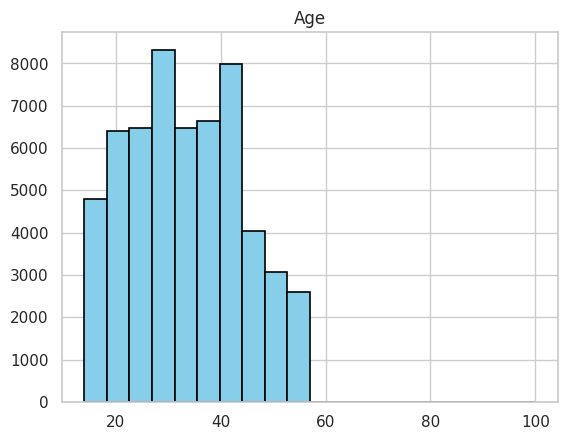

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Age" column
age_data = training_data.select("Age").toPandas()

# Plot the histogram
plt.hist(age_data["Age"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Age')
plt.show()

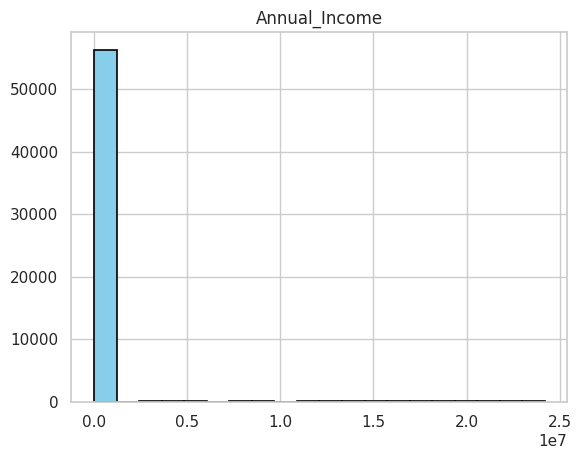

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Annual_Income" column
data = training_data.select("Annual_Income").toPandas()

# Plot the histogram
plt.hist(data["Annual_Income"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Annual_Income')
plt.show()

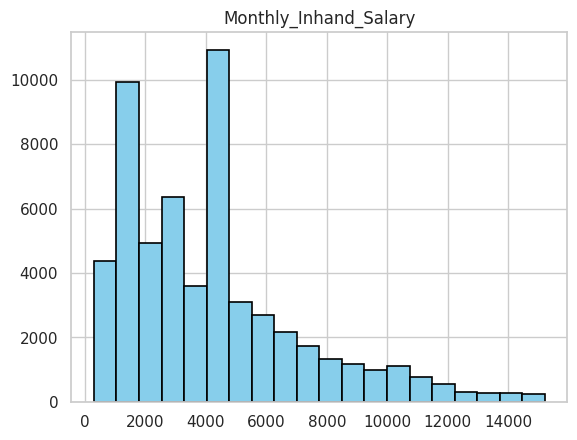

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Monthly_Inhand_Salary" column
data = training_data.select("Monthly_Inhand_Salary").toPandas()

# Plot the histogram
plt.hist(data["Monthly_Inhand_Salary"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Monthly_Inhand_Salary')
plt.show()

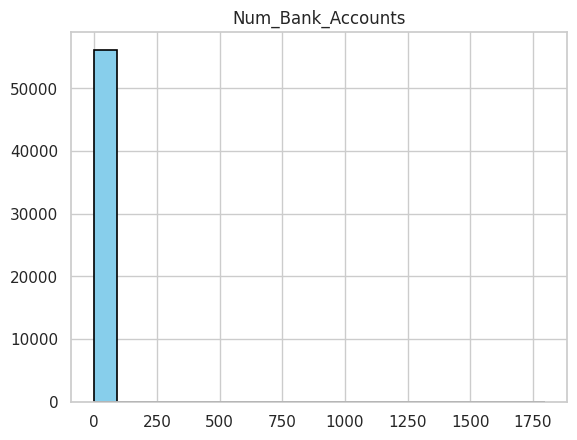

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Num_Bank_Accounts" column
data = training_data.select("Num_Bank_Accounts").toPandas()

# Plot the histogram
plt.hist(data["Num_Bank_Accounts"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Num_Bank_Accounts')
plt.show()

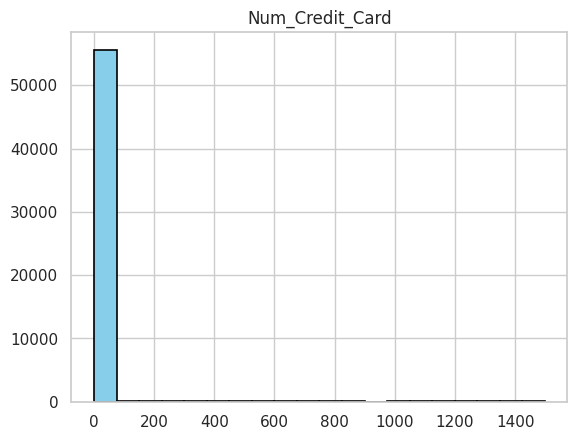

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Num_Credit_Card" column
data = training_data.select("Num_Credit_Card").toPandas()

# Plot the histogram
plt.hist(data["Num_Credit_Card"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Num_Credit_Card')
plt.show()

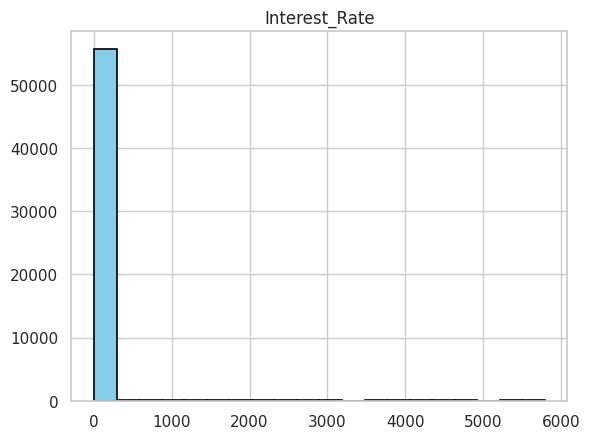

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Interest_Rate" column
data = training_data.select("Interest_Rate").toPandas()

# Plot the histogram
plt.hist(data["Interest_Rate"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Interest_Rate')
plt.show()

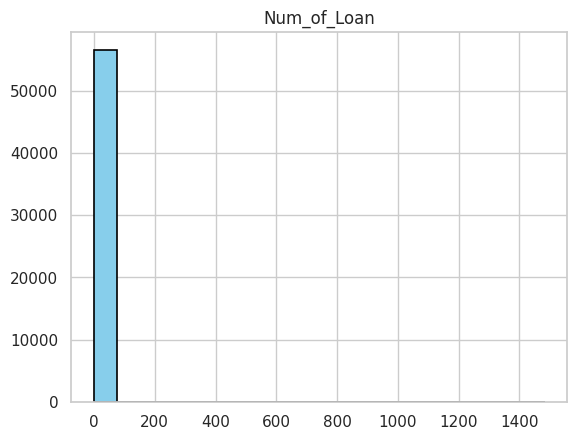

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Num_of_Loan" column
data = training_data.select("Num_of_Loan").toPandas()

# Plot the histogram
plt.hist(data["Num_of_Loan"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Num_of_Loan')
plt.show()

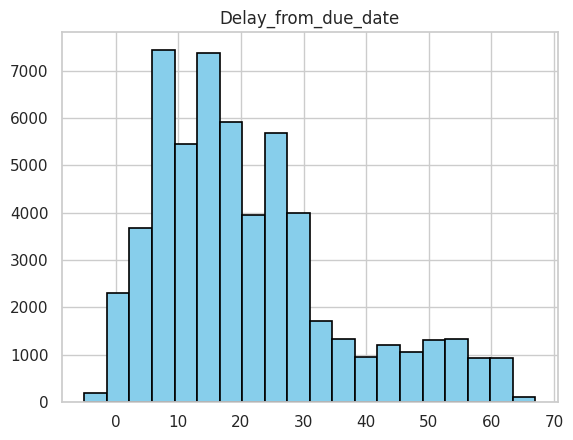

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Delay_from_due_date" column
delay_data = training_data.select("Delay_from_due_date").toPandas()

# Plot the histogram for "Delay_from_due_date"
plt.hist(delay_data["Delay_from_due_date"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Delay_from_due_date')
plt.show()

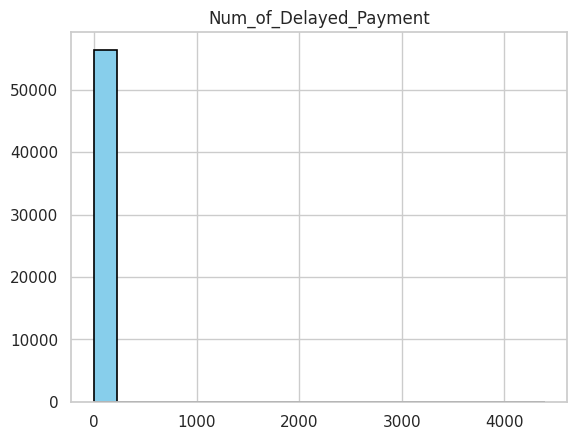

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Num_of_Delayed_Payment" column
delayed_payment_data = training_data.select("Num_of_Delayed_Payment").toPandas()

# Plot the histogram for "Num_of_Delayed_Payment"
plt.hist(delayed_payment_data["Num_of_Delayed_Payment"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Num_of_Delayed_Payment')
plt.show()

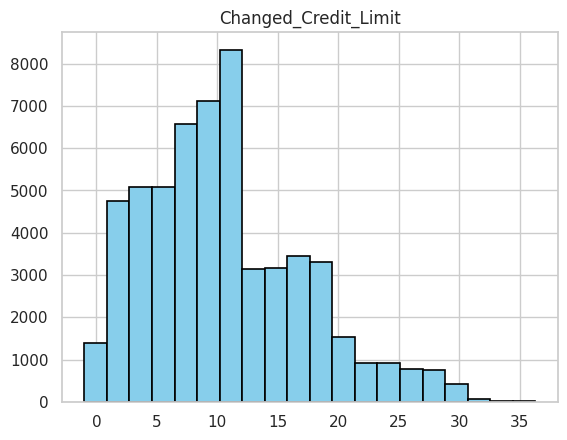

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Changed_Credit_Limit" column
credit_limit_data = training_data.select("Changed_Credit_Limit").toPandas()

# Plot the histogram for "Changed_Credit_Limit"
plt.hist(credit_limit_data["Changed_Credit_Limit"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Changed_Credit_Limit')
plt.show()

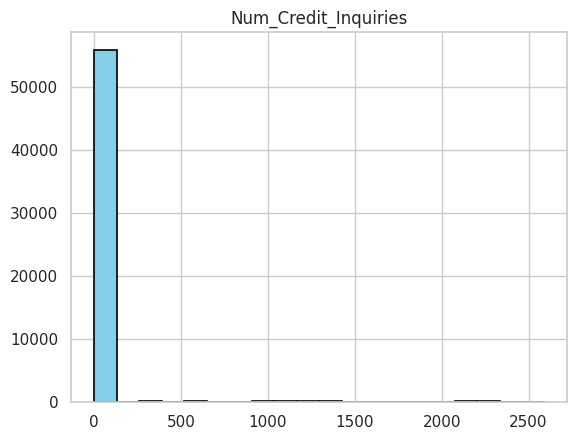

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Num_Credit_Inquiries" column
credit_inquiries_data = training_data.select("Num_Credit_Inquiries").toPandas()

# Plot the histogram for "Num_Credit_Inquiries"
plt.hist(credit_inquiries_data["Num_Credit_Inquiries"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Num_Credit_Inquiries')
plt.show()

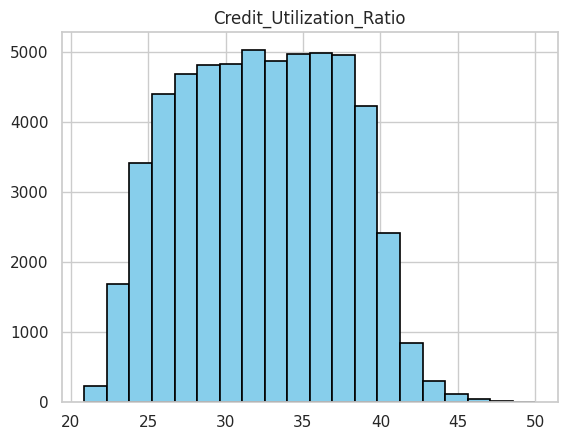

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Credit_Utilization_Ratio" column
utilization_ratio_data = training_data.select("Credit_Utilization_Ratio").toPandas()

# Plot the histogram for "Credit_Utilization_Ratio"
plt.hist(utilization_ratio_data["Credit_Utilization_Ratio"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Credit_Utilization_Ratio')
plt.show()

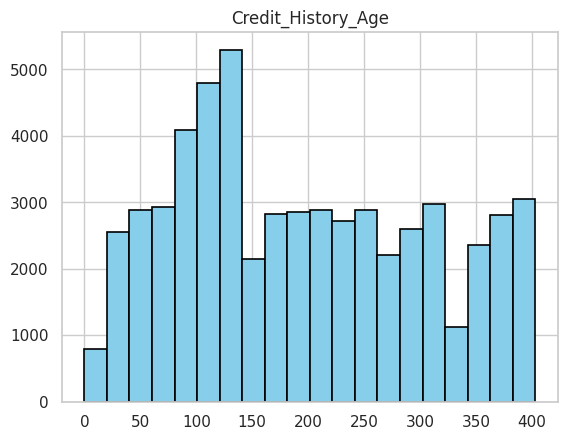

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Credit_History_Age" column
history_age_data = training_data.select("Credit_History_Age").toPandas()

# Plot the histogram for "Credit_History_Age"
plt.hist(history_age_data["Credit_History_Age"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Credit_History_Age')
plt.show()

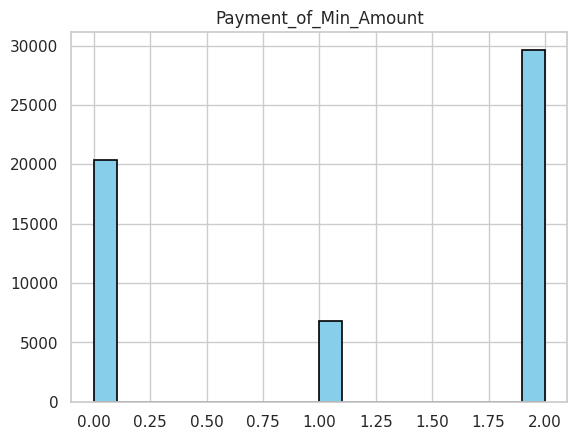

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Payment_of_Min_Amount" column
min_payment_data = training_data.select("Payment_of_Min_Amount").toPandas()

# Plot the histogram for "Payment_of_Min_Amount"
plt.hist(min_payment_data["Payment_of_Min_Amount"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Payment_of_Min_Amount')
plt.show()

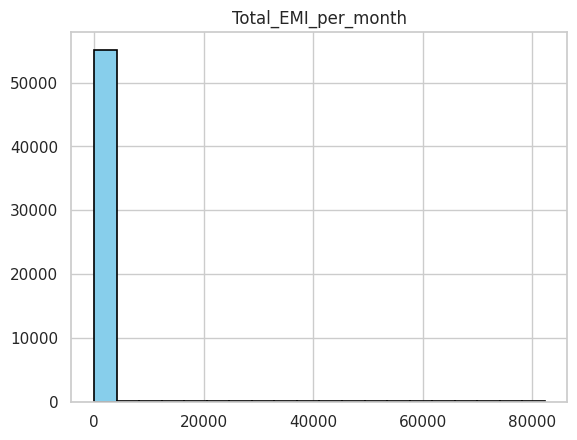

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Total_EMI_per_month" column
emi_data = training_data.select("Total_EMI_per_month").toPandas()

# Plot the histogram for "Total_EMI_per_month"
plt.hist(emi_data["Total_EMI_per_month"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Total_EMI_per_month')
plt.show()

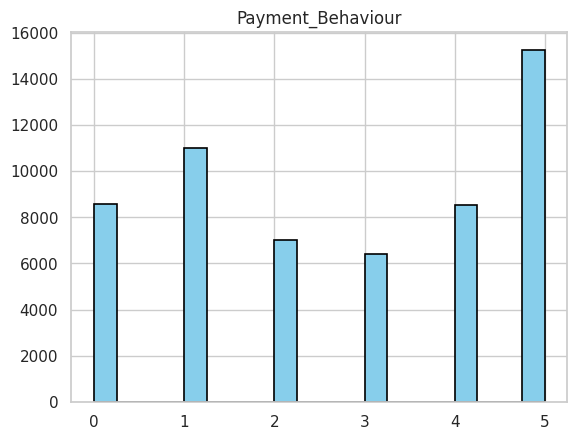

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Payment_Behaviour" column
payment_behaviour_data = training_data.select("Payment_Behaviour").toPandas()

# Plot the histogram for "Payment_Behaviour"
plt.hist(payment_behaviour_data["Payment_Behaviour"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Payment_Behaviour')
plt.show()

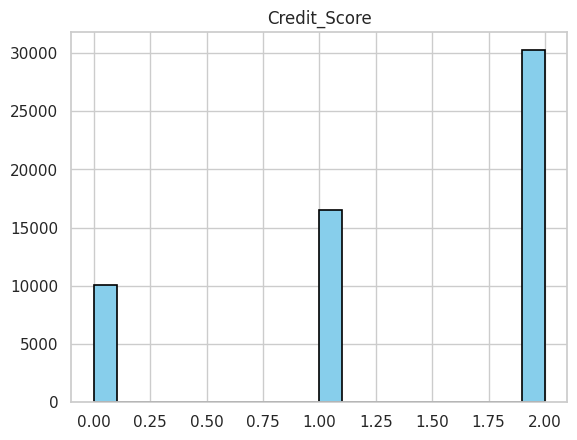

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Credit_Score" column
credit_score_data = training_data.select("Credit_Score").toPandas()

# Plot the histogram for "Credit_Score"
plt.hist(credit_score_data["Credit_Score"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Credit_Score')
plt.show()

Execution time >3min, hence excluded

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Occupation" column
#occ_data = training_data.select("Occupation").toPandas()

# Plot the histogram
#plt.hist(occ_data["Occupation"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
#plt.title('Occupation')
#plt.show()

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Credit_Mix" column


#credit_mix_data = training_data.select("Credit_Mix").toPandas()

# Plot the histogram for "Credit_Mix"
#plt.hist(credit_mix_data["Credit_Mix"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
#plt.title('Credit_Mix')
#plt.show()

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Outstanding_Debt" column
#outstanding_debt_data = training_data.select("Outstanding_Debt").toPandas()

# Plot the histogram for "Outstanding_Debt"
#plt.hist(outstanding_debt_data["Outstanding_Debt"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
#plt.title('Outstanding_Debt')
#plt.show()

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Amount_invested_monthly" column
#invested_amount_data = training_data.select("Amount_invested_monthly").toPandas()

# Plot the histogram for "Amount_invested_monthly"
#plt.hist(invested_amount_data["Amount_invested_monthly"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
#plt.title('Amount_invested_monthly')
#plt.show()

In [ ]:
# Convert the Spark DataFrame to Pandas and select the "Monthly_Balance" column
#monthly_balance_data = training_data.select("Monthly_Balance").toPandas()

# Plot the histogram for "Monthly_Balance"
#plt.hist(monthly_balance_data["Monthly_Balance"], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
#plt.title('Monthly_Balance')
#plt.show()

##Table Correlation

                          Credit_Score  Credit_Mix  Payment_of_Min_Amount  \
Credit_Score                  1.000000    0.445857               0.255957   
Credit_Mix                    0.445857    1.000000               0.587395   
Payment_of_Min_Amount         0.255957    0.587395               1.000000   
Changed_Credit_Limit          0.182555    0.284191               0.466121   
Delay_from_due_date           0.094538    0.202506               0.477291   
Monthly_Inhand_Salary        -0.068193   -0.180577              -0.265718   
Age                          -0.055947   -0.138556              -0.251965   
Outstanding_Debt              0.036262    0.046284               0.464225   
Payment_Behaviour             0.021434    0.053781               0.091030   
Credit_Utilization_Ratio     -0.018996   -0.055313              -0.080577   
Credit_History_Age           -0.017085   -0.067929              -0.073868   
Amount_invested_monthly      -0.011398   -0.015196              -0.020875   

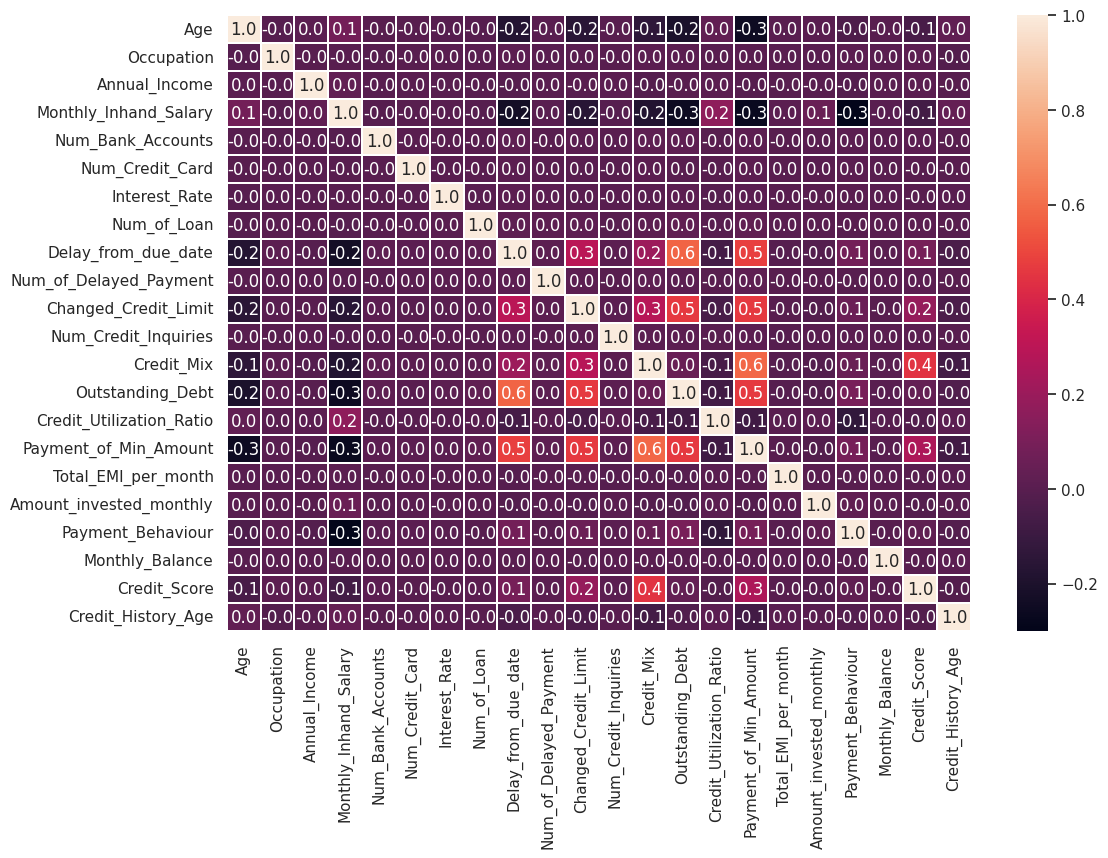

In [ ]:
pandas_data = training_data.toPandas()

def correlation_plot(data=pandas_data):
    numerical_columns = data.select_dtypes(exclude='object').columns

    # Select categorical columns
    categorical_columns = data.select_dtypes(include='object').columns

    # Compute correlation matrix for numerical columns
    numerical_corr = data[numerical_columns].corr()

    # Convert categorical columns to numerical representation
    categorical_data = data[categorical_columns].apply(lambda x: x.astype('category').cat.codes)

    # Concatenate numerical and converted categorical columns
    all_data = pd.concat([data[numerical_columns], categorical_data], axis=1)

    # Compute correlation matrix for all columns
    all_corr = all_data.corr()

    sorted_corr = all_corr['Credit_Score'].abs().sort_values(ascending=False)

    # Display correlation matrix in tabular form, sorted by absolute values of correlation with the target column
    sorted_corr_matrix = all_corr.loc[sorted_corr.index, sorted_corr.index]
    print(sorted_corr_matrix)

    # Plot the correlation matrix
    plt.figure(figsize=[12,8])
    sns.heatmap(all_corr, annot=True, fmt='.1f', linewidth=.2)
    plt.show()

correlation_plot()

In [ ]:
#drop columns with little corr value
column_drop =['Occupation','Annual_Income','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_Credit_Inquiries'
              ,'Credit_Utilization_Ratio','Num_of_Delayed_Payment','Num_of_Loan','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance','Credit_History_Age']
training_data = training_data.drop(*column_drop)

In [ ]:
training_data.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Credit_Mix: integer (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Payment_of_Min_Amount: integer (nullable = true)
 |-- Payment_Behaviour: integer (nullable = true)
 |-- Credit_Score: integer (nullable = true)



# Step 3: Perform Stratified Sampling

In [ ]:
target = 'Credit_Score'

In [ ]:
# Use stratified sampling to split the data into training and testing sets

fractions = training_data.select(target).distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
train_data = training_data.sampleBy(target, fractions, seed=42)
test_data = training_data.subtract(train_data)

In [ ]:
#@title evaluation

def evaluation(prediction, target):
  ac_ev = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="accuracy")
  accuracy = ac_ev.evaluate(prediction)
  f1_ev = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="f1")
  f1_score = f1_ev.evaluate(prediction)
  precision_ev = MulticlassClassificationEvaluator(labelCol= target, predictionCol="prediction", metricName="weightedPrecision")
  precision_score = precision_ev.evaluate(prediction)
  recall_ev = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="weightedRecall")
  recall_score = recall_ev.evaluate(prediction)

  temp = {
      'Accuracy':accuracy,
      'F1 Score': f1_score,
      'Precision':precision_score,
      'Recall':recall_score
  }
  return temp

  #predictionLabel = prediction.select('prediction', target)
  #metrics = MulticlassMetrics(predictionLabel)
  #metrics.confusionMatrix().toArray()

In [ ]:
all_columns = training_data.columns

# Filter out the column named 'credit score'
feature_columns = [col_name for col_name in all_columns if col_name != target]

# Print or use the filtered column names
print(feature_columns)

['Age', 'Monthly_Inhand_Salary', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Payment_of_Min_Amount', 'Payment_Behaviour']


In [ ]:
def change(train_data, test_data):
  assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
  train_data = train_data.repartition(500)
  scaler = StandardScaler(inputCol="features", outputCol="scaled_features",withStd=True, withMean=False)
  pipeline = Pipeline(stages=[assembler, scaler])
  pipeline_model = pipeline.fit(train_data)
  train_data = pipeline_model.transform(train_data)
  test_data = pipeline_model.transform(test_data)
  return train_data, test_data

In [ ]:
train_data_scaled, test_data_scaled= change(train_data,test_data)

Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(labelCol=target, featuresCol="scaled_features")
DTmodel = dt.fit(train_data_scaled)
DTprediction = DTmodel.transform(test_data_scaled)

In [ ]:
#@title Fine Tune
tuned_dt = DecisionTreeClassifier(labelCol=target, featuresCol="scaled_features")
param_grid = ParamGridBuilder().addGrid(tuned_dt.maxDepth, [5, 10, 15]).addGrid(tuned_dt.maxBins, [32, 64, 128]).build()
tuned_evaluator = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")

cross_val = CrossValidator(estimator = tuned_dt, estimatorParamMaps=param_grid, evaluator=tuned_evaluator, numFolds=3)

cv_model = cross_val.fit(train_data_scaled)
best_dt_model = cv_model.bestModel

In [ ]:
best_maxBins = best_dt_model.getOrDefault('maxBins')
best_maxDepth = best_dt_model.getOrDefault('maxDepth')

print("Best maxBins:", best_maxBins)
print("Best maxDepth:", best_maxDepth)

best_dt_prediction = best_dt_model.transform(test_data_scaled)

Best maxBins: 32
Best maxDepth: 5


In [ ]:
#@title evaluation dt
DT_first_ev = evaluation(DTprediction, target)
DT_best_ev = evaluation(best_dt_prediction , target)

print('Results before tuning: ')
print(DT_first_ev)

print('Results After tuning: ')
print(DT_best_ev)

Results before tuning: 
{'Accuracy': 0.675690658782223, 'F1 Score': 0.6802377595122866, 'Precision': 0.7001701587720977, 'Recall': 0.675690658782223}
Results After tuning: 
{'Accuracy': 0.675690658782223, 'F1 Score': 0.6802377595122866, 'Precision': 0.7001701587720977, 'Recall': 0.675690658782223}


Random forest

In [ ]:
rf = RandomForestClassifier(labelCol=target, featuresCol="scaled_features", seed=42)
rfmodel = rf.fit(train_data_scaled)
rfpredriction = rfmodel.transform(test_data_scaled)

In [ ]:
#@title Fine Tune
tuned_rf = RandomForestClassifier(labelCol=target, featuresCol="features", seed=42)
param_grid = ParamGridBuilder().addGrid(tuned_rf.numTrees,[10,20,30]).addGrid(tuned_rf.maxDepth,[5,6,8]).addGrid(tuned_rf.impurity, ['gini']).build()
tuned_evaluator = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")

crossval = CrossValidator(estimator=tuned_rf, estimatorParamMaps=param_grid, evaluator=tuned_evaluator, numFolds=3)

cv_model = crossval.fit(train_data_scaled)
best_model = cv_model.bestModel

In [ ]:
best_numTrees = best_model.getOrDefault('numTrees')
best_maxDepth = best_model.getOrDefault('maxDepth')
best_impurity = best_model.getOrDefault('impurity')

print("Best numTrees:", best_numTrees)
print("Best maxDepth:", best_maxDepth)
print("Best impurity:", best_impurity)

best_prediction = best_model.transform(test_data_scaled)

Best numTrees: 30
Best maxDepth: 8
Best impurity: gini


In [ ]:
#@title evaluation
RF_first_ev = evaluation(rfpredriction, target)
RF_best_ev = evaluation(best_prediction , target)

print('Results before tuning: ')
print(RF_first_ev)

print('Results After tuning: ')
print(RF_best_ev)

Results before tuning: 
{'Accuracy': 0.6687565308254964, 'F1 Score': 0.6726855674990858, 'Precision': 0.6920788232900097, 'Recall': 0.6687565308254962}
Results After tuning: 
{'Accuracy': 0.6725182863113898, 'F1 Score': 0.6761317302131058, 'Precision': 0.6931391475697484, 'Recall': 0.6725182863113898}


Naive bayes

In [ ]:
nb = NaiveBayes(modelType='gaussian', featuresCol='scaled_features', labelCol=target)
NBmodel = nb.fit(train_data_scaled)
NBprediction = NBmodel.transform(test_data_scaled)

In [ ]:
#@title fine tune

tuned_nb = NaiveBayes(modelType='gaussian', labelCol=target, featuresCol="scaled_features")
param_grid = ParamGridBuilder().addGrid(tuned_nb.smoothing, [0.3, 0.5, 1.0]).build()
tuned_evaluator = MulticlassClassificationEvaluator(labelCol=target, metricName="accuracy")

cross_val = CrossValidator(estimator = tuned_nb, estimatorParamMaps=param_grid, evaluator=tuned_evaluator, numFolds=3)

cv_model = cross_val.fit(train_data_scaled)
best_nb_model = cv_model.bestModel

In [ ]:
best_smoothing = best_nb_model.getOrDefault('smoothing')
print("Best smoothing:", best_smoothing)

best_nb_prediction = best_nb_model.transform(test_data_scaled)

Best smoothing: 0.3


In [ ]:
#@title evaluation nb
nb_first_ev = evaluation(NBprediction, target)
nb_best_ev = evaluation(best_nb_prediction , target)

print('Results before tuning: ')
print(nb_first_ev)

print('Results After tuning: ')
print(nb_best_ev)

Results before tuning: 
{'Accuracy': 0.6227478517970988, 'F1 Score': 0.626038794109336, 'Precision': 0.6550696897177404, 'Recall': 0.6227478517970988}
Results After tuning: 
{'Accuracy': 0.6227478517970988, 'F1 Score': 0.626038794109336, 'Precision': 0.6550696897177404, 'Recall': 0.6227478517970988}


Scikit-Learn

- User-friendly API, offers a wide variety of machine learning algorithms
- Easy to use for beginners
- Offers a wide range of tools for data exploration and visualization, including libraries like Pandas, Matplotlib, and Seaborn.

Spark MLlib

- Requires knowledge of Spark's ecosystem and concepts like DataFrames, Transformers, Estimators, and Pipelines.
- Steeper learning curve for beginners
- Limited visualization capabilities
- Relies on Spark DataFrame operations can be integrated with visualization libraries such as Matplotlib and Plotly.
- Users may need to convert data to Pandas DataFrame format using "toPandas()" for more extensive visualization tasks.

Both libraries offer functionalities for data preprocessing, including handling missing values, scaling features, encoding categorical variables, and splitting datasets into training and testing sets. Both libraries offer utilities for hyperparameter tuning, such as GridSearchCV and RandomizedSearchCV in Scikit-Learn and CrossValidator in Spark MLlib. Both libraries offer tools to evaluate and assess the model performance  including accuracy, precision, recall, F1-score, ROC curves, and more.
Overall, both Spark MLlib and Scikit-Learn are powerful libraries for machine learning tasks, each with its own set of strengths and considerations. Scikit-Learn excels in ease of use, extensive documentation, and a rich ecosystem of tools and algorithms for traditional machine learning on single machines. On the other hand, Spark MLlib is tailored for big data environments, offering scalability, distributed computing, and integration with the broader Spark ecosystem for end-to-end data processing and analysis. Choosing between the two depends on the specific requirements of the project, including dataset size, computational resources, and the need for scalability.